# 6.1.2 확률적 경사 하강법(SGD)
---

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[keys]

# 6.1.4 모멘텀
---

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

# 6.1.5 AdaGrad
---

In [1]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += gards[key] * gards[key]
            params[key] -= self.lr * grads[key]/(np.sqrt(self.h[key])+1e-7)

# 6.2 가중치의 초깃값
---

### 6.2.2 은닉층의 활성화값 분포
---

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.random.randn(1000,100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z

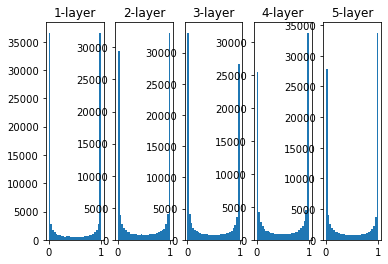

In [6]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1)+"-layer")
    plt.hist(a.flatten(), 30, range = (0, 1))
plt.show()